In [1]:
# Check TensorFlow version
import tensorflow as tf
print(tf.__version__) # should be 2.5.0+
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from timeit import default_timer as timer 
assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()

2.9.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-08-03 08:04:12.557841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-03 08:04:13.517753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 7376 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:81:00.0, compute capability: 6.1


In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 8s 0us/step


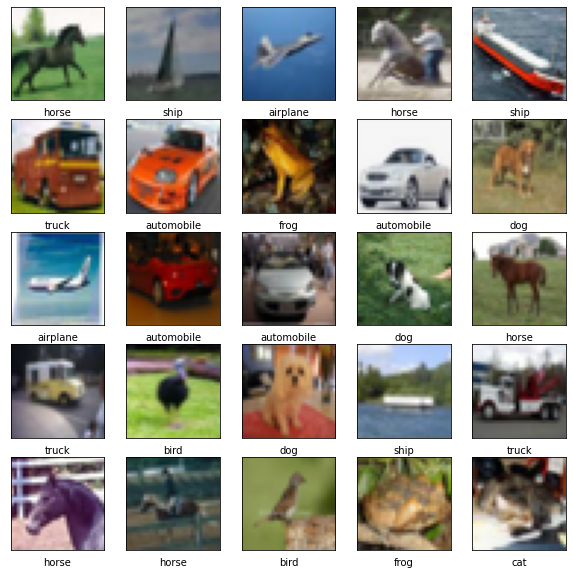

(32, 32, 3)

In [3]:
start = np.random.randint(0,40000)
plt.figure(figsize=(10,10))
for j in range(25):
    i = start + j
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(class_names[int(train_labels[i])])
plt.show()
train_images[i].shape

In [4]:
import sys
sys.path.append('/home/me.docker/work/semi_supervised/augment/')
from augment.rand_augment import distort_image_with_randaugment

In [6]:
# distort_image_with_randaugment(train_images[i],num_layers=2,magnitude=7)

In [7]:
import sys
sys.path.append('/home/me.docker/work/semi_supervised/models/')
from resnets import cifar_WRN_28_n, cifar_wide_resnet

In [8]:
# model = cifar_WRN_28_n(2)
# model.summary()
model = cifar_wide_resnet(28, 2, 'preactivated', shortcut_type='B', dropout=0.5, l2_reg=5e-4)

2022-08-03 08:05:23.400448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7376 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:81:00.0, compute capability: 6.1


In [9]:
BATCH_SIZE = 256
# Create datasets 
# flip, whitening, rand crop ( pad 36, crop 32), (optional: cutout, mix)
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Make datasets faster
train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_data, test_data, len(train_data), len(test_data)

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>,
 196,
 40)

In [ ]:
# Compile the model
scce = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
logs = dict()
models = dict()
epochs = 50
for lr in [1e-4, 5e-4]:
    model = cifar_wide_resnet(28, 2, 'preactivated', shortcut_type='B', dropout=0.2, l2_reg=0.0001)
    model.compile(loss=scce, # since labels aren't one-hot, use sparse_categorical_crossentropy
                  optimizer=tf.keras.optimizers.Adam(lr=lr),
                  metrics=["accuracy"])

    # Fit model 
    logs[lr] = model.fit(train_data,
                        epochs=epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))
    models[lr] = model

/home/me.docker/.conda/envs/tf/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50


2022-08-03 08:05:35.934455: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-03 08:05:36.599665: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-03 08:05:36.600800: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-03 08:05:36.600867: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-03 08:05:36.601804: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-03 08:05:36.601937: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


196/196 [==============================] - 29s 111ms/step - loss: 2.2426 - accuracy: 0.3171 - val_loss: 3.3371 - val_accuracy: 0.2306
Epoch 2/50
196/196 [==============================] - 20s 103ms/step - loss: 1.8831 - accuracy: 0.4522 - val_loss: 2.4453 - val_accuracy: 0.3485
Epoch 3/50
196/196 [==============================] - 20s 103ms/step - loss: 1.7357 - accuracy: 0.5117 - val_loss: 2.0559 - val_accuracy: 0.4360
Epoch 4/50
196/196 [==============================] - 20s 104ms/step - loss: 1.6154 - accuracy: 0.5582 - val_loss: 1.8694 - val_accuracy: 0.4947
Epoch 5/50
196/196 [==============================] - 20s 104ms/step - loss: 1.5213 - accuracy: 0.5932 - val_loss: 1.7612 - val_accuracy: 0.5308
Epoch 6/50
196/196 [==============================] - 20s 104ms/step - loss: 1.4403 - accuracy: 0.6220 - val_loss: 1.5394 - val_accuracy: 0.5866
Epoch 7/50
196/196 [==============================] - 20s 104ms/step - loss: 1.3740 - accuracy: 0.6458 - val_loss: 1.5161 - val_accuracy: 0.5

In [ ]:
# history.history.keys()
plt.figure()
colors = ['r', 'g', 'b', 'k', 'p']
for lr, c  in zip(logs, colors[:len(logs)]):
    plt.plot(logs[lr].history['val_accuracy'], color=c, label=lr)
    plt.plot(logs[lr].history['accuracy'], color=c, linestyle='--')
plt.grid()
plt.ylim([0.6, 0.95])
plt.legend()